<span style='font-size: 2.5em'><b>São Paulo Housing 🏡</b></span><br/>
<span style='font-size: 1.5em'>Predict the median housing price in São Paulo apartments</span>

<span style="background-color: #ffc351; padding: 4px; font-size: 1em;"><b>Sprint #1</b></span>



### **D2APR: Aprendizado de Máquina e Reconhecimento de Padrões** (IFSP, Campinas) <br/>
**Prof**: Samuel Martins (Samuka) <br/>

#### Projeto de Estudo

**Aluno**: Carlos Danilo Tomé e Lucas Galdino de Camargo

**Dataset**: https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019

This data is about 13,000 apartments in São Paulo City - Brazil available in Kaggle platform.

**Final Goal**: Predict housing price in São Paulo.

---

## 🎯 Sprint Goals
- Frame the problem
- Get the data
- Data cleaning
- Simple EDA to gain insights
- Initial data preprocessing
- Train a (single) ML algorithm with all features and default hyperparameters
---

### 0. Imports, settings and read data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


from sklearn.ensemble import RandomForestRegressor


sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

## 0. Get data and Pre Processed

In [2]:
# Load train data
housing_train = pd.read_csv('./datasets/housing_train.csv', sep=';')

X_train = housing_train.drop(['Price'], axis=1).copy()
y_train = housing_train['Price'].copy()

In [3]:
class pre_processing_transform(BaseEstimator, TransformerMixin):
    
    # Classe que realiza Pré Processamento para os problemas 1 e 2
    # Objetivo: Transformador customizado e adaptado ao sklearn
    # Observacoes: Com esta configuração essa classe ganha os atributos "fit","fit_transform" e "transform", nativas do sklearn
    # Parametros: "adc_faturamento_per_capita" -> se True adiciona a coluna "faturamento_per_capita". Default : False
    
    def __init__(self):
        return None
    
    def fit(self,X,y = None):
        return self
    
    def transform(self, X, y = None):
        temp = X.copy()
        
        # Create Columns
        temp['Total Rooms']            = temp['Rooms'] + temp['Toilets'] + temp['Suites']
        temp['Total Bedrooms']         = temp['Rooms'] + temp['Suites']
        
        
        # Add District Rate
        district = pd.read_csv('./datasets/district_information.csv', sep=';')
        
        temp = pd.merge(temp, district[['District','district_rate','Latitude_district','Longitude_district']],
                           how='left', on=['District'])

        # Drop object Column District   
        temp.drop(['District'], axis=1, inplace=True)
        
        min_y= -23.8
        max_y= -23.2
        min_x= -46.95
        max_x= -46

        # Remove outliers and replace as NAN
        temp['Latitude'][(temp['Latitude'] < min_y )  |
                   (temp['Longitude'] < min_x )  |
                   (temp['Latitude']  > max_y )  |
                   (temp['Longitude'] > max_x )  
                   ]= np.nan

        temp['Longitude'][(temp['Latitude'] < min_y ) |
                           (temp['Longitude'] < min_x )  |
                           (temp['Latitude']  > max_y )  |
                           (temp['Longitude'] > max_x )  
                           ]= np.nan
        
        # Imput NA values with mean point neigborhood
        temp.Latitude = np.where(temp.Latitude.isnull()
                                  , temp.Latitude_district # If Latitude is null replace with Latitude_district
                                  , temp.Latitude # else, keep the original value
                                 )
        temp.Longitude = np.where(temp.Longitude.isnull()
                                          , temp.Longitude_district # If Latitude is null replace with Longitude_district
                                          , temp.Longitude # else, keep the original value
                                         )

        # Drop temp Columns
        temp.drop(['Latitude_district', 'Longitude_district'], axis=1, inplace=True)
        
      
        return temp

In [4]:
# Load a pre processed pipeline
loaded_preprocessed_pipeline = joblib.load('./preprocessed_pipeline.pkl')

In [5]:
# Função que avalia os modelos de Regressão
# Queremos focar nas métricas 
# R²: pela sua interpretabilidade ( por estar entre 0 e 1) 
# RSME: ( pois mensura em valores o erro médio)

def resultados_regressao(modelo, string_nome_modelo, parametros ):

    # Create a full pipeline

    full_pipeline = Pipeline([
            ('preprocessing', loaded_preprocessed_pipeline),
            (string_nome_modelo, modelo)
    ])

    # GridSearch
    grid = GridSearchCV(full_pipeline,parametros,cv=5, scoring = 'neg_mean_squared_error', return_train_score=True, verbose=1)

    # Treina o modelo
    grid.fit(X_train, y_train)

    # Melhor Combinação de Parametros
    best_model = grid.best_estimator_

    print('Melhores parametros encontrados: \n',grid.best_params_)  
    
    # Print the mediam RSME of all folds
    
    n_folds = 5
    split_keys = [f'split{i}_test_score' for i in range(n_folds)]
    best_index = grid.best_index_

    rmse_scores = []

    for key in split_keys:
        neg_mse_score = grid.cv_results_[key][best_index]
        rmse_scores.append(np.sqrt(-neg_mse_score))

    best_rmse = np.mean(rmse_scores)
    best_rmse_std = np.std(rmse_scores)


    print(f'Best RMSE score of all folds: {best_rmse} +- {best_rmse_std}')
    
    # Plot graph 1
    y_train_pred = best_model.predict(X_train)
    
    sns.scatterplot(x=y_train_pred, y=y_train)
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.title('Median housing value - Prediction vs Real - Linear Regression')
    
    plt.show()
    
    # Plot graph 2
    residual = y_train - y_train_pred
    
    sns.scatterplot(x=y_train_pred, y=residual)
    plt.xlabel('Prediction')
    plt.ylabel('Residual')
    plt.title('Median housing value - Prediction vs Residual - Linear Regression')
    
    
    

## 🔲 1. Testing Models




### 📄 1.1. Context

**São Paulo** is the most populous city in Brazil with a population about 12.39 million in 2020 acordding IBGE [1]. 

It also the largest economy in U.S., boasting a $3.2 trillion gross state product (GSP) as of 2019. [3]. If California were a sovereign nation (2020), it would rank as the world's fifth largest economy [4].


**References:** <br/>
[1] https://cidades.ibge.gov.br/brasil/sp/sao-paulo/panorama

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


Melhores parametros encontrados: 
 {'random_forest_test__min_samples_leaf': 3, 'random_forest_test__random_state': 42}
Best RMSE score of all folds: 235003.2544199815 +- 58830.876605625155


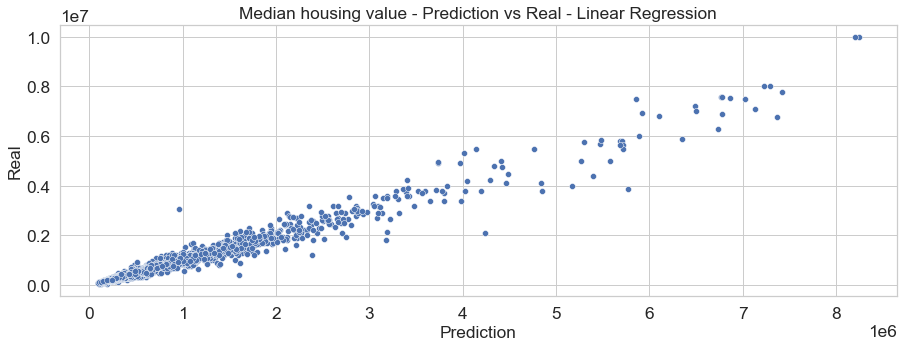

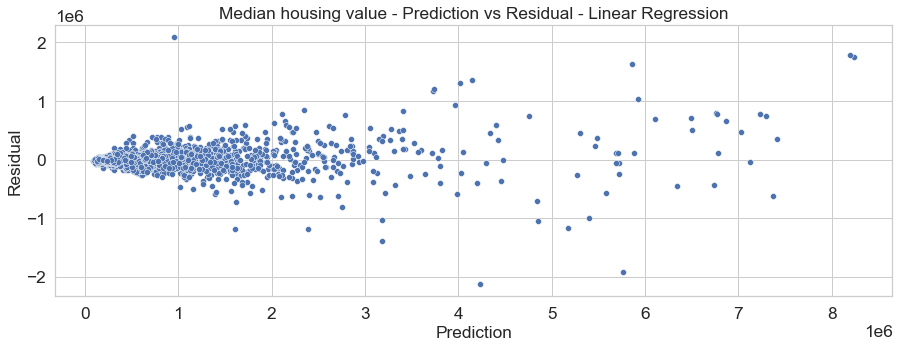

In [8]:
modelo_2 = RandomForestRegressor()


string_nome_modelo = 'random_forest_test'


parametros = [{string_nome_modelo+'__min_samples_leaf':[3,8],
              #'random_forest_test__min_samples_split':[50,80],
              #'random_forest_test__n_estimators':[250,500,750],
              'random_forest_test__random_state': [42]
}]


resultados_regressao(modelo_2, string_nome_modelo, parametros)

In [12]:
from sklearn.svm import SVR

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.8min finished


Melhores parametros encontrados: 
 {'support_vector_regressor__C': 8, 'support_vector_regressor__degree': 5, 'support_vector_regressor__epsilon': 0.3, 'support_vector_regressor__kernel': 'poly'}
Best RMSE score of all folds: 629745.664653205 +- 65758.45681839716


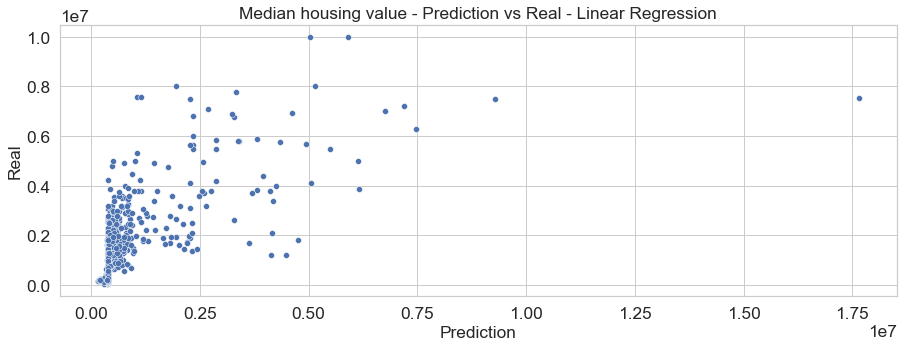

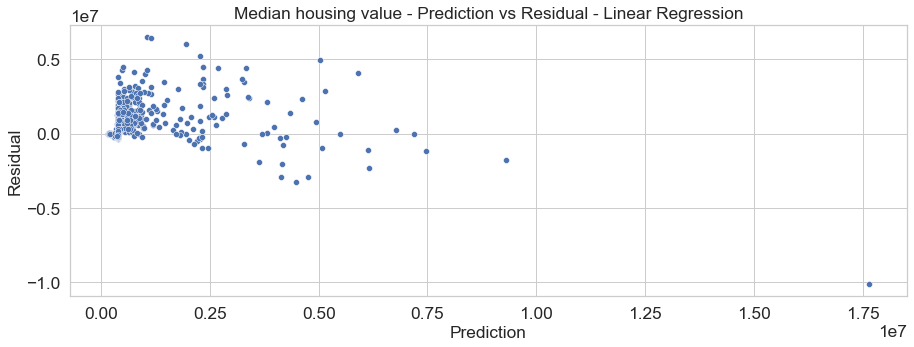

In [16]:
modelo_3 = SVR()

string_nome_modelo = 'support_vector_regressor'

parametros = [{
    
    string_nome_modelo+'__kernel':['linear','poly','rbf'] , 
    string_nome_modelo+'__degree':[5] ,
    string_nome_modelo+'__epsilon':[0.2,0.3] ,
    string_nome_modelo+'__C':[3,5,8]

}]

resultados_regressao(modelo_3, string_nome_modelo, parametros)

In [17]:
from sklearn import linear_model

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   41.3s finished


Melhores parametros encontrados: 
 {'ridge_linear_model__alpha': 15, 'ridge_linear_model__fit_intercept': True, 'ridge_linear_model__normalize': False, 'ridge_linear_model__random_state': 0, 'ridge_linear_model__solver': 'sag'}
Best RMSE score of all folds: 382401.82890519284 +- 49860.37436901304


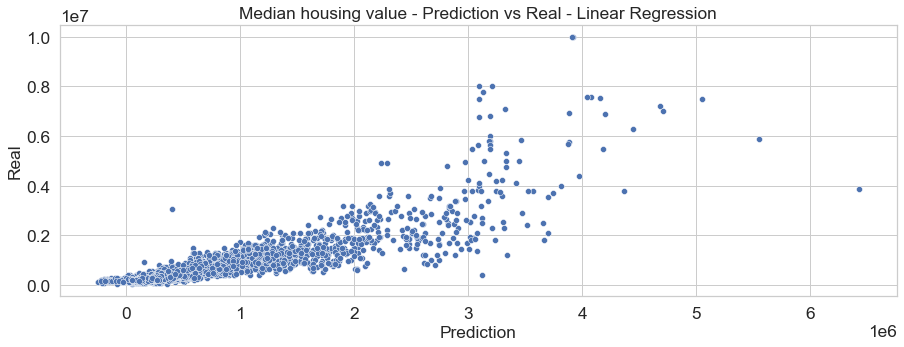

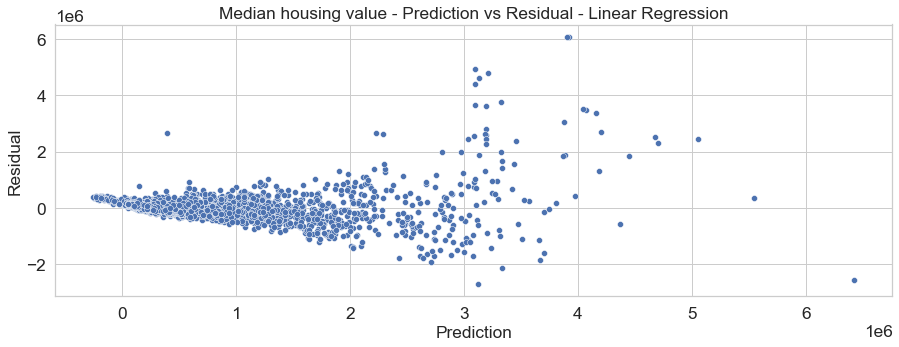

In [22]:
modelo_4 = linear_model.Ridge()


string_nome_modelo = 'ridge_linear_model'

parametros = [{
    
    string_nome_modelo+'__alpha': [5,8,12,15] , 
    string_nome_modelo+'__random_state': [0],
    string_nome_modelo+'__solver': ['svd','cholesky','lsqr','sag','lbfgs'] ,
    string_nome_modelo+'__fit_intercept': [True,False] ,
    string_nome_modelo+'__normalize': [True,False]
    
}]

resultados_regressao(modelo_4, string_nome_modelo, parametros)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    8.1s finished


Melhores parametros encontrados: 
 {'Lasso_linear_model__alpha': 10, 'Lasso_linear_model__fit_intercept': True, 'Lasso_linear_model__normalize': True, 'Lasso_linear_model__positive': True, 'Lasso_linear_model__random_state': 0, 'Lasso_linear_model__selection': 'random'}
Best RMSE score of all folds: 388374.8543743394 +- 48839.01208626994


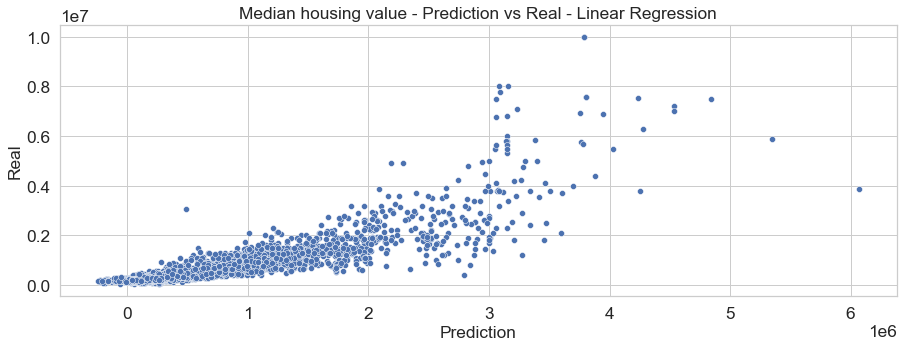

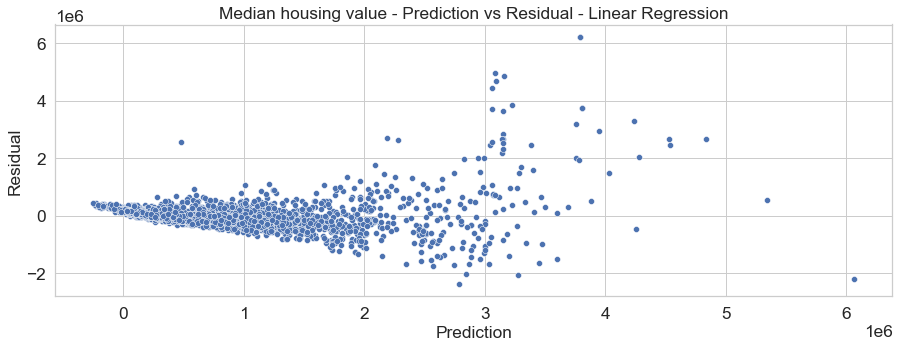

In [25]:
modelo_5 = linear_model.Lasso()


string_nome_modelo = 'Lasso_linear_model'

parametros = [{
    
    string_nome_modelo+'__alpha': [0,1,5,10] , 
    string_nome_modelo+'__random_state': [0],
    string_nome_modelo+'__positive': [True] ,
    string_nome_modelo+'__fit_intercept': [True,False] ,
    string_nome_modelo+'__normalize': [True,False],
    string_nome_modelo+'__selection': ['random']
    
}]

resultados_regressao(modelo_5, string_nome_modelo, parametros)

In [29]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 167.5min finished


Melhores parametros encontrados: 
 {'AdaBoostRegressor__base_estimator': RandomForestRegressor(), 'AdaBoostRegressor__learning_rate': 1, 'AdaBoostRegressor__loss': 'square', 'AdaBoostRegressor__n_estimators': 50, 'AdaBoostRegressor__random_state': 0}
Best RMSE score of all folds: 214747.4905970279 +- 49698.84526852791


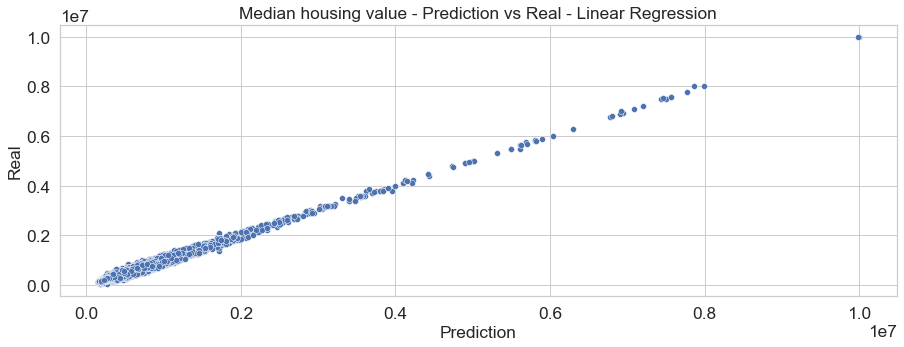

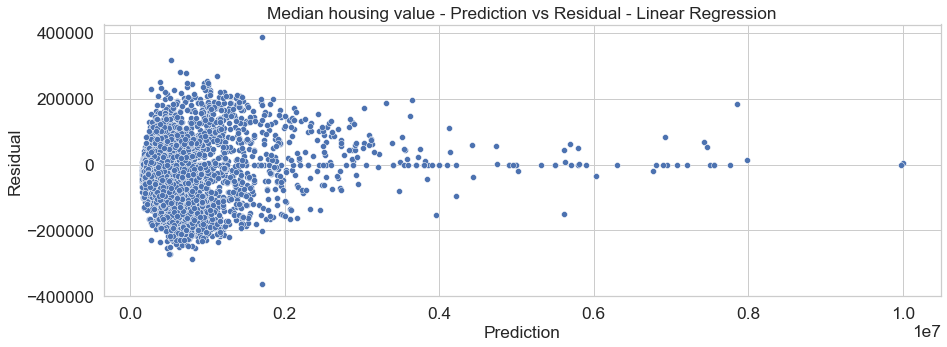

In [31]:
modelo_6 = AdaBoostRegressor()


string_nome_modelo = 'AdaBoostRegressor'

parametros = [{
    
    string_nome_modelo+'__base_estimator': [DecisionTreeRegressor(max_depth = 10), RandomForestRegressor()] , 
    string_nome_modelo+'__random_state': [0],
    string_nome_modelo+'__n_estimators': [50,100] ,
    string_nome_modelo+'__learning_rate': [0.5,1,5] ,
    string_nome_modelo+'__loss': ['linear','square']
}]

resultados_regressao(modelo_6, string_nome_modelo, parametros)

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.7min finished


Melhores parametros encontrados: 
 {'GradientBoosting__criterion': 'friedman_mse', 'GradientBoosting__learning_rate': 0.1, 'GradientBoosting__n_estimators': 100, 'GradientBoosting__random_state': 0, 'GradientBoosting__subsample': 1}
Best RMSE score of all folds: 229774.61249105888 +- 50938.65632567301


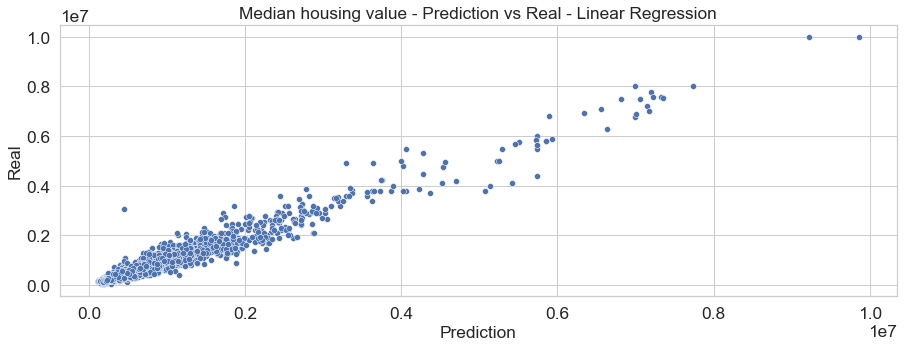

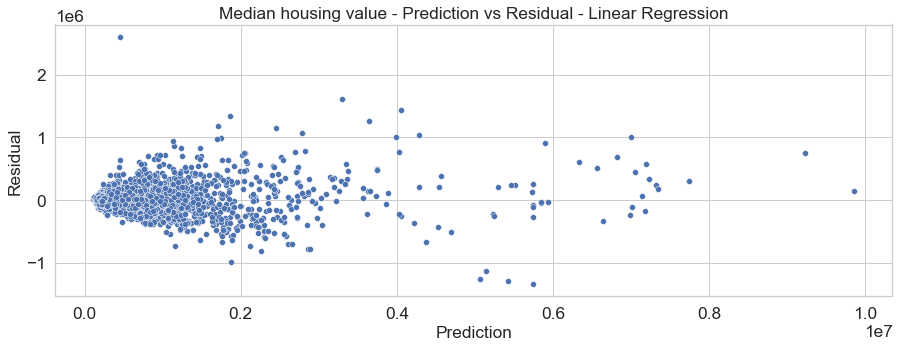

In [34]:
modelo_7 = GradientBoostingRegressor()


string_nome_modelo = 'GradientBoosting'

parametros = [{
    
    string_nome_modelo+'__subsample': [0.1,0.5,1,5] , 
    string_nome_modelo+'__random_state': [0],
    string_nome_modelo+'__n_estimators': [50,100] ,
    string_nome_modelo+'__learning_rate': [0.1,0.5,1,5] ,
#    string_nome_modelo+'__loss': ['squared_error','square'] ,
    string_nome_modelo+'__criterion': ['friedman_mse','squared_error','mse']
    
}]

resultados_regressao(modelo_7, string_nome_modelo, parametros)